##Distribution of Sum of Binomially Distributed Dollar Values in ROI

We take a set of projects, each having a certain number of dollars and a certain ratio of the area of overlap with our regioin of to the total area of the project. For each project, we calcuate a binomial distribution with parameters n = number of dollars and p = area ratio, which describes the probability of any number of dollars from 0 to the total number of dollars landing in the area of interest. (For the sake of efficiency, we won't use the full number of dollars per se, but bundles of $10,000, so for a 1 million dollar project, n = 100.) We want to describe the distribution of the sum of dollars from all the projects landing in the area of interest, which we will calculate explicitly.

For more background see this paper:
https://statistics.stanford.edu/sites/default/files/SOL%20ONR%20467.pdf

and this Stack Exchange post:
http://math.stackexchange.com/questions/29998/sum-of-independent-binomial-random-variables-with-different-probabilities

First we need our function that calculates the density distribution of the sum of two random variables. What it's doing is for each i in 0:dollars in project a and each j in 0:dollars in project b, multiplying p(i dollars from a lands in region of interest) x p(j dollars from b lands in area of interest), and then adding up the probability of all the situations where the sum k = i+j, i.e. for k = 5, p(k=5) = p(i=0) x p(j=5) + p(i=1) x p(j=4) + ... + p(i=5) x p(j=0).

In [76]:
# explicitly calculate distribution of sum of discrete random variables
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, rv_discrete
from random import randint, uniform
import time

def sumDists(a, b):
    """ Takes two numpy matrices representing discrete probability distributions for two variables and output
    a new distribution for the sum of the two variables. """
    
    # ensure matrices
    a = np.matrix(a)
    b = np.matrix(b)
    
    # because of the following computation, make a matrix with more columns than rows
    if a.shape[1] > b.shape[1]:
        a, b = b, a
    
    # explicitly multiply the probability distributions
    m = a.T * b
    
    # initialize the final result, element 1 = count 0
    result = np.matrix(np.zeros(a.shape[1] + b.shape[1] - 1))
    
    # add the probabilities, always adding to the next subseqent slice
    for i in range(m.shape[0]):
        result[:,i:m.shape[1]+i] = result[:,i:m.shape[1]+i] + m[i,:]
        
    return np.array(result).ravel()


Next, we'll make up some projects. The projects range in size from \$100k to \$1.5m, and ratio of the area of overlap ranges from 0 to 1.

In [118]:
# number of projects
projects = 100

# number of dollars in each project
lengths = [randint(10,150) for p in range(projects)]

# ratio of area of interest overlap to area of project
probs = [uniform(0,1) for p in range(projects)]

Finally, add up all the distributions to find the distribution of sums. For reference, we'll keep track of the time it takes.

In [119]:
# start clock
start = time.time()

# initialize distribution of sums with distribution of first project
sum_dist = binom.pmf(range(lengths[0]+1),lengths[0],probs[0])

# add distribution of each project in turn
for proj in range(1,projects):
    proj_dist = binom.pmf(range(lengths[proj]+1),lengths[proj],probs[proj])
    sum_dist = sumDists(sum_dist, proj_dist)

# density distribution, N are sums of dollars, p are corresponding probabilities

d = {'N':range(len(sum_dist)),'p':sum_dist}
sum_dist_df = pd.DataFrame(d)

# cumulative distribution
cum_dist = [a for a in sum_dist]
for i in range(2,len(cum_dist)):
    cum_dist[i] = cum_dist[i] + cum_dist[i-1]
    
d = {'N':range(len(cum_dist)),'p':cum_dist}

cum_dist_df = pd.DataFrame(d)

# time
end = time.time() - start

And display result.

Time taken: 2.27 seconds


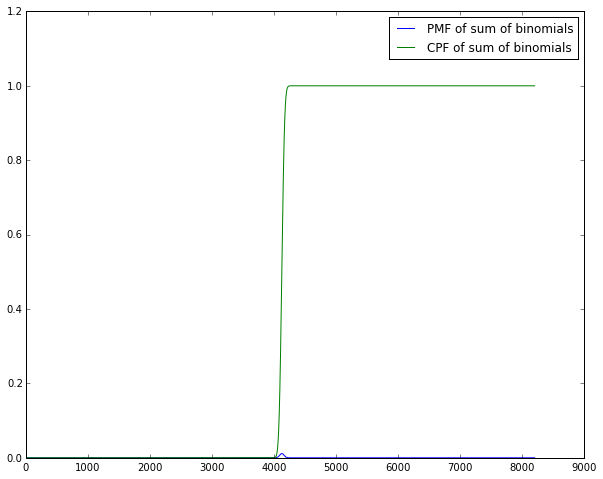

In [120]:
plt.figure(figsize=(10,8))
plt.plot(sum_dist_df['N'],sum_dist_df['p'],label = 'PMF of sum of binomials')
plt.plot(cum_dist_df['N'],cum_dist_df['p'],label = 'CPF of sum of binomials')
plt.legend()

print"Time taken: %.2f seconds" %end 

To draw from the distribution of sums:

(array([   12.,   133.,   567.,  1722.,  2976.,  2730.,  1354.,   416.,
           85.,     5.]),
 array([ 3995. ,  4022.2,  4049.4,  4076.6,  4103.8,  4131. ,  4158.2,
         4185.4,  4212.6,  4239.8,  4267. ]),
 <a list of 10 Patch objects>)

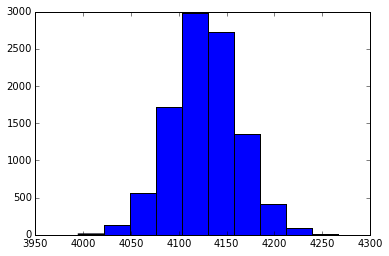

In [121]:
draw_dist = rv_discrete(values=(sum_dist_df['N'],sum_dist_df['p']))
samp = draw_dist.rvs(size=10000)
plt.hist(samp)

The above describes the density and cumulative distributions for the sum of dollars (sum of \$10,000 bundles) landing in the area of interest from all projects. We'll use the expected value for this distribution as our assumed sum and multiply by \$10,000.

In [89]:
expected_val = (np.array(sum_dist_df['N']) * np.array(sum_dist_df['p'])).sum() 
print "Expected value $%d" %(expected_val * 10000)

Expected value $38709587


For SIMEX we need to describe the distribution of errors. Our measured values are the expected value of the distribution of sums. We can think of the distribution of errors as the same distribution as the distribution of sums, shifted down the axis of possible values so that the expected error value is 0 and the distribution has suppport -(expected dollars):(highest possible sum - expected dollars). This is easily accomplished by subtracting expected dollars from each value in the distribution.

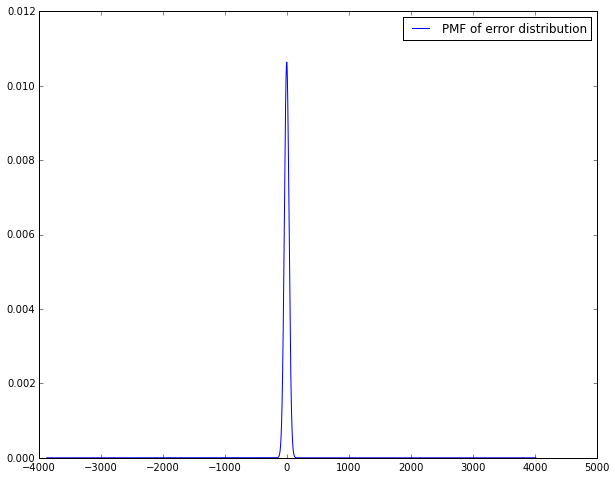

In [96]:
d = {'N':sum_dist_df['N'] - expected_val, 'p':sum_dist_df['p']}
error_dist_df = pd.DataFrame(d)

plt.figure(figsize=(10,8))
plt.plot(error_dist_df['N'],error_dist_df['p'],label = 'PMF of error distribution')
plt.legend()

We want to be able to send a user the inputs necessary to run simulations such as SIMEX. If we were to send the inputs demonstrated above in a csv, the files would be impractically large. Instead, we will calculate the distributions as demonstrated above, and output csv files containing the distributions, which can be feasibly delivered to a user.

In [101]:
sum_dist_df.to_csv("sum_dist.csv", index=False)